In [5]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib import ticker
from tqdm import tqdm

# 激活函数
def sigmod(Z):
    A = 1 / (1 + np.exp(-Z))
    cache = Z
    return A, cache

def relu(Z):
    A = np.maximum(0, Z)
    cache = Z
    return A, cache

def softmax(Z):
    cache = Z
    Z -= np.max(Z, axis=0, keepdims=True)
    # Compute softmax
    e_Z = np.exp(Z)
    A = e_Z / np.sum(e_Z, axis=0, keepdims=True)
    return A, cache

# 随机初始化权重参数
def init_parameters(layers_dims):
    '''
    :param layers_dims: 网络中每层节点的数量列表
    :return:
    '''
    '''
        z_i = w_i * x_{i-1} + b_i
        第i层w的维度为：(n_i, n_{i-1})
        第i层b的维度为：(n_i, 1)
    '''
    params = {}
    for i in range(1, len(layers_dims)):
        params["W" + str(i)] = np.random.randn(layers_dims[i], layers_dims[i-1]) * np.sqrt(2 / (layers_dims[i-1]))
        params["b" + str(i)] = np.zeros((layers_dims[i], 1))

        assert (params["W" + str(i)].shape == (layers_dims[i], layers_dims[i-1]))
        assert (params["b" + str(i)].shape == (layers_dims[i], 1))
    return params

def init_zeros(layers_dims):
    parameters = {}
    # np.random.seed(3)
    for i in range(1, len(layers_dims)):
        parameters["W" + str(i)] = np.zeros((layers_dims[i], layers_dims[i-1]))
        parameters["b" + str(i)] = np.zeros((layers_dims[i], 1))

        assert (parameters["W" + str(i)].shape == (layers_dims[i], layers_dims[i - 1]))
        assert (parameters["b" + str(i)].shape == (layers_dims[i], 1))
    return parameters

def init_random(layers_dims):
    parameters = {}
    # np.random.seed(3)
    for i in range(1, len(layers_dims)):
        parameters["W" + str(i)] = np.random.randn(layers_dims[i], layers_dims[i - 1]) * 0.001
        parameters["b" + str(i)] = np.zeros((layer_dims[i], 1))

        assert (parameters["W" + str(i)].shape == (layers_dims[i], layers_dims[i - 1]))
        assert (parameters["b" + str(i)].shape == (layers_dims[i], 1))
    return parameters

In [6]:

'''
 前向传播:
    1. 计算预测值
    2. 计算激活函数值
'''
def linear_forward(A, W, b):
    '''
    :param A: 上一层的输出值
    :param W: 权重矩阵
    :param b: 偏向量
    :return:
    '''
    Z = np.dot(W, A) + b
    cache = (A, W, b)
    assert (Z.shape == (W.shape[0], A.shape[1]))
    return (Z, cache)

def linear_activation_forward(A, W, b, activation):
    Z, linear_cache = linear_forward(A, W, b)
    activation_cache = []
    if activation == "sigmod":
        A, activation_cache = sigmod(Z)
    if activation == "relu":
        A, activation_cache = relu(Z)
    if activation == "softmax":
        A, activation_cache = softmax(Z)
    cache = (linear_cache, activation_cache)
    return A, cache

def L_model_forward(X, parameters):
    L = len(parameters) // 2
    A = X
    caches = []
    for i in range(1, L):
        prev_A = A # 上一层的输出值
        A, cache = linear_activation_forward(prev_A, parameters["W" + str(i)], parameters["b" + str(i)], "relu")
        caches.append(cache)
    # 输出层的输出值: AL
    AL, cache = linear_activation_forward(A, parameters["W" + str(L)], parameters["b" + str(L)], "softmax")
    caches.append(cache)
    assert (AL.shape == (10, X.shape[1]))
    return AL, caches

# 计算成本函数
def compute_cost(AL, y):
    m = AL.shape[1]
    # cost = - (np.sum(y * np.log(AL) + (1 - y) * np.log(1 - AL), axis=1)) / m
    cost = - (np.sum(y * np.log(AL + 1e-8), axis=1)) / m
    return cost

'''
    反向传播：
        第一步：计算激活函数的梯度
        第二步：计算线性的梯度
'''
# sigmod 激活函数的梯度
def sigmod_backward(dA, cache):
    Z = cache
    a = 1 / (1 + np.exp(-Z))
    dZ = dA * a * (1 - a)
    assert (Z.shape == dZ.shape)
    return dZ

# relu 激活函数的梯度
def relu_backward(dA, cache):
    Z = cache
    dZ = np.array(dA, copy=True)
    dZ[Z <= 0] = 0
    assert (Z.shape == dZ.shape)
    return dZ

def softmax_backward(dA, cache):
    Z = cache
    N = Z.shape[0]  # Assuming Z is a column vector
    dZ = np.zeros_like(Z)
    for i in range(N):
        for j in range(N):
            dZ[i] += dA[j] * Z[i] * (int(i == j) - Z[j])
    return dZ

# 线性部分的梯度
def linear_backward(dZ, cache):
    # A表示当前层的输入
    A, W, b = cache
    # 样本的个数
    m = A.shape[1]
    dW = np.dot(dZ, A.T) * (1 / m)
    db = np.sum(dZ, axis=1, keepdims=True) * (1 / m) # keepdims=True, 表示保持维度
    dA_prev = np.dot(W.T, dZ) # 表示前一层输出的梯度，也就是当前层的输入值的梯度
    return dA_prev, dW, db

# 整合一层的线性和激活函数的梯度
def linear_activation_backward(dA, cache, activation):
    linear_cache, activation_cache = cache
    if activation == "sigmod":
        # 先计算激活函数的梯度
        dZ = sigmod_backward(dA, activation_cache)
        # 计算线性部分的梯度
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
    if activation == "relu":
        dZ = relu_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
    if activation == "softmax":
        # dZ = softmax_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dA, linear_cache)

    return dA_prev, dW, db

# 整合反向传播的梯度下降过程
def L_model_backward(AL, y, caches):
    '''
    :param AL: 前向传播的输出值
    :param y: 输出标签值
    :param caches: 存储了前向传播过程中计算得到的线性部分和激活部分的相关值
    :return:
    '''
    grads = {} # 存储参数梯度值，用于更新每层的参数
    y = y.reshape(AL.shape)
    L = len(caches)

    dZ = AL + 1e-8 - y

    dA_prev, dW, db = linear_activation_backward(dZ, caches[L-1], "softmax")
    grads["dA" + str(L)], grads["dW" + str(L)], grads["db" + str(L)] = dA_prev, dW, db
    for i in reversed(range(L-1)):
        dA = grads["dA" + str(i+2)]
        dA_prev, dW, db = linear_activation_backward(dA, caches[i], "relu")
        grads["dA" + str(i+1)], grads["dW" + str(i+1)], grads["db" + str(i+1)] = dA_prev, dW, db

    return grads

# 更新每一层的参数
def update_parameters(parameters, grads, learning_rate):
    '''
    :param parameters: 参数
    :param grads: 梯度值
    :param learning_rate: 学习率
    :return:
    '''
    L = len(parameters) // 2
    for i in range(L):
        parameters["W" + str(i+1)] -= learning_rate * grads["dW" + str(i+1)]
        parameters["b" + str(i+1)] -= learning_rate * grads["db" + str(i+1)]
    return parameters

def eval_model(test_bacthes, parameters):
    correct_num = 0
    total_num = 0
    for X, Y in test_bacthes:
        total_num += Y.shape[1]
        # print(X.shape)
        # print(Y.shape)
        # print(correct_num)
        correct_num += prediction(X, Y, parameters)
    return correct_num / total_num

# 封装成一个L层神经网络
def L_layer_model(train_bathces, test_bacthes, layer_dims,learning_rate=0.0075, iteration_num=3000, print_cost=True, isPlot=True, initialization="he"):
    '''
    :param X: 输入特征
    :param Y:  输出标签
    :param layer_dims: 层数向量
    :param learning_rate: 学习率
    :param iteration_num: 迭代次数
    :param print_cost: 是否打印成本值
    :param isPlot: 是否绘制学习曲线
    :return: 返回学习到的模型参数
    '''
    # 1.初始化参数W和b
    if initialization == "zeros":
        parameters = init_zeros(layer_dims)
    elif initialization == "random":
        parameters = init_random(layer_dims)
    elif initialization == "he":
        parameters = init_parameters(layer_dims)
    else:
        print("请选择正确的初始化参数的方法！")
    costs = []
    test_accuracy_epoch = []
    for i in tqdm(range(iteration_num)):
        for X, Y in train_bathces:
            AL, caches = L_model_forward(X, parameters)  # 2.前向传播
            cost = compute_cost(AL, Y)  # 3.计算成本值
            grads = L_model_backward(AL, Y, caches)  # 4.反向传播
            parameters = update_parameters(parameters, grads, learning_rate)  # 5.更新参数

        test_accuracy = eval_model(test_bacthes, parameters)
        test_accuracy_epoch.append(test_accuracy * 100)
        if (i + 1) % 50 == 0:
            print(f"第{i}轮测试准确率为：{test_accuracy * 100: .4} % ")
    if isPlot:
        x = [i for i in range(iteration_num)]
        # print("costs", costs)
        # print("np.array(costs)", np.array(costs))
        y = test_accuracy_epoch
        _, ax = plt.subplots()
        ax.plot(x, y)
        ax.set_xlabel("Epoch")
        ax.set_ylabel("Accuracy(%)")
        ax.set_title(f"learning_rate={learning_rate}")
        ax.yaxis.set_major_locator(ticker.MaxNLocator(integer=True))
        ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
        plt.show()
    return parameters

def prediction(X, Y, parameters):
    # 进行一次前向传播计算预测值
    AL, caches = L_model_forward(X, parameters)
    return np.sum(np.argmax(Y, axis=0, keepdims=True) == np.argmax(AL, axis=0, keepdims=True))

def f1_score(prediction_Y, Y):
    tp, fp, fn = 0, 0, 0
    for i in range(prediction_Y.shape[1]):
        if prediction_Y[0, i] == Y[0, i] and Y[0, i] == 1:
            tp += 1
        if prediction_Y[0, i] == 1 and Y[0, i] == 0:
            fp += 1
        if prediction_Y[0, i] == 0 and Y[0, i] == 1:
            fn += 1
    P = tp / (tp + fp) if tp + fp != 0 else 0
    R = tp / (tp + fn) if tp + fn != 0 else 0
    return 2*P*R / (P+R) if P+R != 0 else 0

def plot_decision_boundary(X, Y, parameters):
    minx1, maxx1 = X[0, :].min() - 0.3, X[0, :].max() + 0.3
    minx2, maxx2 = X[1, :].min() - 0.3, X[1, :].max() + 0.3
    x = np.linspace(minx1, maxx1, 100)
    y = np.linspace(minx2, maxx2, 100)
    meshX, meshY = np.meshgrid(x, y)
    edge_data = np.vstack((meshX.ravel(), meshY.ravel()))
    print(X.shape)
    print(edge_data.shape)
    meshZ = prediction(edge_data, parameters).reshape(meshX.shape)
    print(meshX.shape)
    plt.contourf(meshX, meshY, meshZ, cmap=plt.cm.Spectral)
    plt.scatter(X[0, :], X[1, :], c=Y, marker=".", cmap=plt.cm.Spectral)
    plt.contour(meshX, meshY, meshZ, cmap=plt.cm.Spectral)
    plt.show()

In [7]:
# 将批量的数据集划分成大小为mini_batch_size的小批次数据集
def random_mini_batches(X, Y, mini_batch_size=64, seed=3):
    # np.random.seed(seed)
    m = X.shape[1] # 样本的数量
    mini_batches = []

    # 1. 第一步：打乱顺序
    permuation = np.random.permutation(m) # 产生一个0~m-1的随机排列
    shuffled_X = X[:, permuation] # 以数组的形式取X中的数据
    shuffled_Y = Y[:, permuation]

    # 2. 第二步：分割数据集
    num_complete_minibatches = np.math.floor(m / mini_batch_size) # 批次数
    for k in range(num_complete_minibatches):
        mini_bacth_X = shuffled_X[:, k*mini_batch_size : (k+1)*mini_batch_size]
        mini_bacth_Y = shuffled_Y[:, k*mini_batch_size : (k+1)*mini_batch_size]
        mini_batches.append((mini_bacth_X, mini_bacth_Y))

    # 3. 第三步：如果m不是mini_batch_size的整数倍，那么剩余的样本需要重新整合到一个mini-batch中
    if m % mini_batch_size != 0:
        mini_bacth_X = shuffled_X[:, num_complete_minibatches*mini_batch_size : m]
        mini_bacth_Y = shuffled_Y[:, num_complete_minibatches*mini_batch_size : m]
        mini_batches.append((mini_bacth_X, mini_bacth_Y))

    return mini_batches


def load_dataset():
    train_df = pd.read_csv("../dataset/mnist/mnist_train.csv")
    test_df = pd.read_csv("../dataset/mnist/mnist_test.csv")
    train_Y = train_df.iloc[:, 0].values
    print(train_Y.shape)
    train_X = train_df.iloc[:, 1:].values
    print(train_X.shape)
    test_Y = test_df.iloc[:, 0].values
    print(test_Y.shape)
    test_X = test_df.iloc[:, 1:].values
    print(test_X.shape)
    return train_X, train_Y.reshape(1, -1), test_X, test_Y.reshape(1, -1)

def one_shot(Y):
    _, c = Y.shape
    one_Y = np.zeros((10, c))
    for i in range(c):
        one_Y[Y[0][i]][i] = 1
    return one_Y

(60000,)
(60000, 784)
(10000,)
(10000, 784)
235


 10%|█         | 50/500 [00:34<05:19,  1.41it/s]

第49轮测试准确率为： 96.71 % 


 20%|██        | 100/500 [01:09<04:41,  1.42it/s]

第99轮测试准确率为： 97.49 % 


 30%|███       | 150/500 [01:43<04:09,  1.40it/s]

第149轮测试准确率为： 97.58 % 


 40%|████      | 200/500 [02:18<03:32,  1.41it/s]

第199轮测试准确率为： 97.71 % 


 50%|█████     | 250/500 [02:53<02:53,  1.44it/s]

第249轮测试准确率为： 97.73 % 


 60%|██████    | 300/500 [03:27<02:13,  1.50it/s]

第299轮测试准确率为： 97.77 % 


 70%|███████   | 350/500 [04:01<01:42,  1.46it/s]

第349轮测试准确率为： 97.78 % 


 80%|████████  | 400/500 [04:36<01:11,  1.39it/s]

第399轮测试准确率为： 97.78 % 


 90%|█████████ | 450/500 [05:10<00:33,  1.47it/s]

第449轮测试准确率为： 97.82 % 


100%|██████████| 500/500 [05:45<00:00,  1.45it/s]

第499轮测试准确率为： 97.83 % 


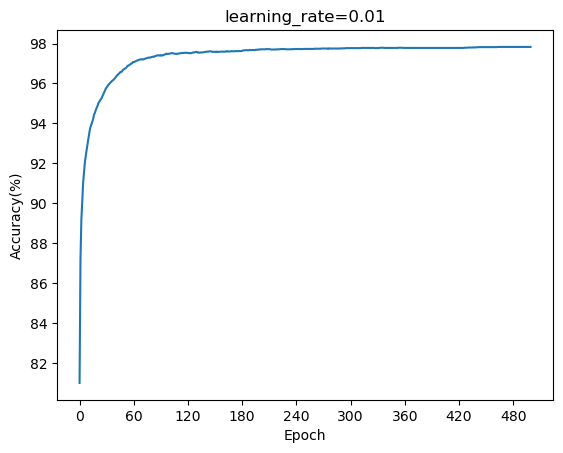

In [8]:
np.random.seed(3) # 保证每次得到的都是相同的随机数

train_X, train_Y, test_X, test_Y = load_dataset()

# 将每个训练的特征压缩成一个大的一维特征向量
train_X = train_X.T # (784, 60000)
test_X = test_X.T # (784, 10000)
# print(train_set_x)

# 归一化特征向量
train_X = train_X / 255
test_X = test_X / 255

train_Y = one_shot(train_Y)
test_Y = one_shot(test_Y)

# 批量化数据
train_batches = random_mini_batches(train_X, train_Y, 256, 3)
test_batches = random_mini_batches(test_X, test_Y, 256, 3)

print(len(train_batches))

# 使用封装好的神经网络进行训练
layer_dims = [784, 256, 128, 32, 10] # 构建一个五层的神经网络， 输入层的神经元个数是输入特征向量的个数
parameters = L_layer_model(train_batches, test_batches, layer_dims, learning_rate=0.01, iteration_num=500, print_cost=True, isPlot=True)

# 用训练得到的参数进行预测
# prediction_train = prediction(train_X, parameters)
# prediction_test = prediction(test_Y, parameters)

# print("训练集准确率：", 100 - np.mean(np.abs(prediction_train - train_Y)) % 100)
# print("测试集准确率：", 100 - np.mean(np.abs(prediction_test - test_Y)) % 100)

# 计算f1—score
# train_score = f1_score(prediction_train, train_Y)
# test_score = f1_score(prediction_test, test_Y)
# print("train_score: ", train_score)
# print("test_score：", test_score)